# Description

Describe what we're trying to do and and what we're trying to predict.


In [31]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from multiprocessing import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from scipy import stats
from subprocess import check_output
import math 
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn import model_selection
from sklearn.feature_selection import RFE
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV as CCV

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import xgboost as xgb
    
pd.set_option('display.max_columns', 144)
pd.set_option('display.max_rows', 200)
os.chdir('E:\\GitHub\\MLTrainer')



# ELT

In [2]:
file = 'data\\nfl.csv'
try:
    data = pd.read_csv(file, quotechar='"', sep=',', skipinitialspace=True, engine='python')
    print("Data imported")
except:
    print("Error importing file" + os.getcwd())
    
data = data.loc[data['score_home'].isnull() == False]

Data imported


In [3]:
print("Data Shape: " + str(data.shape))
print(data.info())
data.tail()

Data Shape: (1602, 14)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1602 entries, 0 to 1601
Data columns (total 14 columns):
schedule_date          1602 non-null object
schedule_season        1602 non-null int64
schedule_week          1602 non-null object
schedule_playoff       1602 non-null bool
team_home              1602 non-null object
score_home             1602 non-null float64
score_away             1602 non-null float64
team_away              1602 non-null object
stadium                1602 non-null object
stadium_neutral        1602 non-null bool
weather_temperature    1592 non-null float64
weather_wind_mph       1592 non-null float64
weather_humidity       186 non-null float64
weather_detail         513 non-null object
dtypes: bool(2), float64(5), int64(1), object(6)
memory usage: 165.8+ KB
None


,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
1597,1/13/2019,2018,Division,True,New England Patriots,41.0,28.0,Los Angeles Chargers,Gillette Stadium,False,26.0,3.0,NaN,NaN
1598,1/13/2019,2018,Division,True,New Orleans Saints,20.0,14.0,Philadelphia Eagles,Mercedes-Benz Superdome,False,72.0,0.0,NaN,DOME
1599,1/20/2019,2018,Conference,True,Kansas City Chiefs,31.0,37.0,New England Patriots,Arrowhead Stadium,False,19.0,14.0,NaN,NaN
1600,1/20/2019,2018,Conference,True,New Orleans Saints,23.0,26.0,Los Angeles Rams,Mercedes-Benz Superdome,False,72.0,0.0,NaN,DOME
1601,2/3/2019,2018,Superbowl,True,Los Angeles Rams,3.0,13.0,New England Patriots,Mercedes-Benz Stadium,True,72.0,0.0,NaN,DOME


In [4]:
try:
    data['score_delta'] = data.score_home - data.score_away
except:
    print("Could not create target")

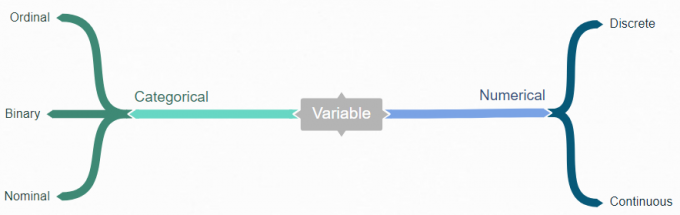

In [16]:
data2 =[]
for f in data.columns:
    #print(f, data[f].dtype)
    # Defining the role
    if f == 'score_delta':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
         
    # Defining the level
    #Can be different each time, ensure you set to what you want in the target.  For instance, you could set this to home winning as binary.
    if f == 'score_delta':
        level = 'numerical-descrete'
        
    elif f == 'schedule_date' or f == "schedule_week" or f == "schedule_season" or f == "score_home" or f == "score_away":
        level = 'numerical-descrete'
    
    elif f == 'stadium_neutral' or f == 'schedule_playoff':
        level = 'categorical-binary'    
        
    elif f == 'weather_temperature' or f == 'weather_wind_mph' or f == 'weather_humidity':
        level = 'numerical-continuous'    
        
    elif data[f].dtype == 'object':
        level = 'categorical-nominal'
   

    else:
        level = 'unknown'
        
    # Initialize keep to True for all variables except for id
    keep = True
    if f in ['stadium','weather_detail','schedule_playoff','stadium_neutral', 'weather_temperature', 'weather_wind_mph', 'weather_humidity', 'schedule_date', 'schedule_season', 'schedule_week']:
        keep = False
    
    # Defining the data type 
    dtype = data[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data2.append(f_dict)
    
meta = pd.DataFrame(data2, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)


meta

,role,level,keep,dtype
varname,,,,
schedule_date,input,numerical-descrete,False,object
schedule_season,input,numerical-descrete,False,int64
schedule_week,input,numerical-descrete,False,object
schedule_playoff,input,categorical-binary,False,bool
team_home,input,categorical-nominal,True,object
score_home,input,numerical-descrete,True,float64
score_away,input,numerical-descrete,True,float64
team_away,input,categorical-nominal,True,object
stadium,input,categorical-nominal,False,object


# Explore & Visualize

In [23]:
v = meta[(meta.keep)].index
data.describe()

,schedule_season,score_home,score_away,weather_temperature,weather_wind_mph,weather_humidity,score_delta
count,1602.000000,1602.000000,1602.000000,1592.000000,1592.000000,186.000000,1602.000000
mean,2015.500000,24.038702,21.547441,61.973618,5.226131,60.580645,2.491261
std,1.708358,10.382431,9.632695,16.172563,4.713981,19.622008,14.282821
min,2013.000000,0.000000,0.000000,-6.000000,0.000000,14.000000,-38.000000
25%,2014.000000,17.000000,15.000000,52.000000,0.000000,47.000000,-6.000000
50%,2015.500000,24.000000,21.000000,68.000000,5.000000,59.000000,3.000000
75%,2017.000000,31.000000,27.000000,72.000000,8.000000,75.750000,11.000000
max,2018.000000,57.000000,56.000000,97.000000,31.000000,100.000000,52.000000


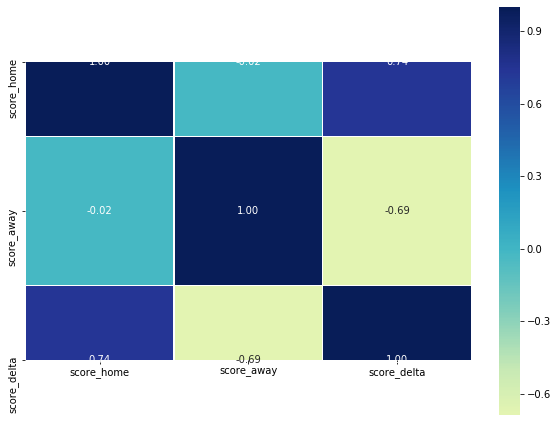

In [21]:
def corr_heatmap(v):
    correlations = data[v].corr()

    # Create color map ranging between two colors
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap="YlGnBu", vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
v = meta[(meta.keep)].index
corr_heatmap(v)

# Data Scrubbing

In [22]:
vars_with_missing = []

for f in data.columns:
    missings = data[data[f].isna() == True][f].count()
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings/data.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

In total, there are 0 variables with missing values


# Feature Engineering and Selection

In [ ]:
data

In [25]:
keeper = ['team_home', 'team_away', 'score_delta']
data = data[keeper]

encoder = ['team_home', 'team_away']
for e in encoder:
    s = data[e]

    # Get one hot encoding of columns B
    one_hot = pd.get_dummies(data[e], prefix=e)
    # Drop column B as it is now encoded
    data = data.drop(e,axis = 1)
    # Join the encoded df
    data = data.join(one_hot)

data

,score_delta,team_home_Arizona Cardinals,team_home_Atlanta Falcons,team_home_Baltimore Ravens,team_home_Buffalo Bills,team_home_Carolina Panthers,team_home_Chicago Bears,team_home_Cincinnati Bengals,team_home_Cleveland Browns,team_home_Dallas Cowboys,team_home_Denver Broncos,team_home_Detroit Lions,team_home_Green Bay Packers,team_home_Houston Texans,team_home_Indianapolis Colts,team_home_Jacksonville Jaguars,team_home_Kansas City Chiefs,team_home_Los Angeles Chargers,team_home_Los Angeles Rams,team_home_Miami Dolphins,team_home_Minnesota Vikings,team_home_New England Patriots,team_home_New Orleans Saints,team_home_New York Giants,team_home_New York Jets,team_home_Oakland Raiders,team_home_Philadelphia Eagles,team_home_Pittsburgh Steelers,team_home_San Diego Chargers,team_home_San Francisco 49ers,team_home_Seattle Seahawks,team_home_St. Louis Rams,team_home_Tampa Bay Buccaneers,team_home_Tennessee Titans,team_home_Washington Redskins,team_away_Arizona Cardinals,team_away_Atlanta Falcons,team_away_Baltimore Ravens,team_away_Buffalo Bills,team_away_Carolina Panthers,team_away_Chicago Bears,team_away_Cincinnati Bengals,team_away_Cleveland Browns,team_away_Dallas Cowboys,team_away_Denver Broncos,team_away_Detroit Lions,team_away_Green Bay Packers,team_away_Houston Texans,team_away_Indianapolis Colts,team_away_Jacksonville Jaguars,team_away_Kansas City Chiefs,team_away_Los Angeles Chargers,team_away_Los Angeles Rams,team_away_Miami Dolphins,team_away_Minnesota Vikings,team_away_New England Patriots,team_away_New Orleans Saints,team_away_New York Giants,team_away_New York Jets,team_away_Oakland Raiders,team_away_Philadelphia Eagles,team_away_Pittsburgh Steelers,team_away_San Diego Chargers,team_away_San Francisco 49ers,team_away_Seattle Seahawks,team_away_St. Louis Rams,team_away_Tampa Bay Buccaneers,team_away_Tennessee Titans,team_away_Washington Redskins
0,22.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-2.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-5.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,3.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-13.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,5.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,10.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8,-26.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Train

In [28]:
data_x = data.drop(['score_delta'], axis=1)
data_y = data['score_delta']

,team_home_Arizona Cardinals,team_home_Atlanta Falcons,team_home_Baltimore Ravens,team_home_Buffalo Bills,team_home_Carolina Panthers,team_home_Chicago Bears,team_home_Cincinnati Bengals,team_home_Cleveland Browns,team_home_Dallas Cowboys,team_home_Denver Broncos,team_home_Detroit Lions,team_home_Green Bay Packers,team_home_Houston Texans,team_home_Indianapolis Colts,team_home_Jacksonville Jaguars,team_home_Kansas City Chiefs,team_home_Los Angeles Chargers,team_home_Los Angeles Rams,team_home_Miami Dolphins,team_home_Minnesota Vikings,team_home_New England Patriots,team_home_New Orleans Saints,team_home_New York Giants,team_home_New York Jets,team_home_Oakland Raiders,team_home_Philadelphia Eagles,team_home_Pittsburgh Steelers,team_home_San Diego Chargers,team_home_San Francisco 49ers,team_home_Seattle Seahawks,team_home_St. Louis Rams,team_home_Tampa Bay Buccaneers,team_home_Tennessee Titans,team_home_Washington Redskins,team_away_Arizona Cardinals,team_away_Atlanta Falcons,team_away_Baltimore Ravens,team_away_Buffalo Bills,team_away_Carolina Panthers,team_away_Chicago Bears,team_away_Cincinnati Bengals,team_away_Cleveland Browns,team_away_Dallas Cowboys,team_away_Denver Broncos,team_away_Detroit Lions,team_away_Green Bay Packers,team_away_Houston Texans,team_away_Indianapolis Colts,team_away_Jacksonville Jaguars,team_away_Kansas City Chiefs,team_away_Los Angeles Chargers,team_away_Los Angeles Rams,team_away_Miami Dolphins,team_away_Minnesota Vikings,team_away_New England Patriots,team_away_New Orleans Saints,team_away_New York Giants,team_away_New York Jets,team_away_Oakland Raiders,team_away_Philadelphia Eagles,team_away_Pittsburgh Steelers,team_away_San Diego Chargers,team_away_San Francisco 49ers,team_away_Seattle Seahawks,team_away_St. Louis Rams,team_away_Tampa Bay Buccaneers,team_away_Tennessee Titans,team_away_Washington Redskins
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [40]:
# prepare models
models = []
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

#models.append(('LRG', LogisticRegression(solver='liblinear')))
#models.append(('KNB', KNeighborsClassifier()))
#models.append(('GNB', GaussianNB()))
#models.append(('XGB', xgb.XGBClassifier(random_state=0)))
#models.append(('RFC', RandomForestClassifier(random_state=0, n_estimators=100)))
#models.append(('DTC', DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=5)))
models.append(('RFR', RandomForestRegressor(random_state=0, n_estimators=100)))
models.append(('XGB', xgb.XGBRegressor(random_state=0)))



# evaluate each model by average and standard deviations of roc auc 
results = []
names = []

for name, m in models:
    kfold = model_selection.KFold(n_splits=5, random_state=0)
    cv_results = model_selection.cross_val_score(m, data_x, data_y, cv=kfold) #, scoring = 'roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RFC: -0.082023 (0.046552)
[16:56:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:56:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:56:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:56:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:56:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB: 0.047978 (0.025856)
RFC: -0.082023 (0.046552)
RFC: -0.082023 (0.046552)


array([-0.09158885, -0.00810733, -0.09954681, -0.06140618, -0.14946451])

# Evaluate

# Deployment to production Notes